# Production Lecture: Bicycle Classifier
## Set up

In [1]:
#hide
! pip install -Uqq fastbook
! pip install duckduckgo_search

import fastbook

fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from duckduckgo_search import ddg_images
from fastcore.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 75.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: lxml
    Found existing installation: lxml 4.5.0
    Uninstalling lxml-4.5.0:
      Successfully uninstalled lxml-4.5.0
  Attempting uninstall: click
    Found existing installation: click 8.1.3
    Uninstalling click-8.1.3:
      Successfully uninstalled click-8.1.3


Search for images in Duckduckgo

In [2]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Searching for 'mountain bicycle photos'


/usr/local/lib/python3.9/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


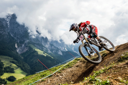

In [3]:
urls = search_images('mountain bicycle photos', max_images=1)
dest = 'images/bicycle.jpg'
download_url(urls[0], dest)

im = Image.open(dest)
im.to_thumb(128,128)

Search for labeled data

In [4]:
bear_types = 'road','mountain','gravel'
path = Path('bicycles')

for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} bicycles'))

Searching for 'road bicycles'
Searching for 'mountain bicycles'
Searching for 'gravel bicycles'


Our folder has image files, as we'd expect:

In [5]:
fns = get_image_files(path)
fns

(#177) [Path('bicycles/gravel/b048900c-3fd1-4583-9062-9aa67d69c299.jpg'),Path('bicycles/gravel/4c773b72-58ac-4078-91be-f86dc48a374b.jpg'),Path('bicycles/gravel/d21df021-7195-42bd-b7cf-e21a10848902.jpg'),Path('bicycles/gravel/f1fd7795-3539-4aff-ae8b-c57a07998d3a.jpg'),Path('bicycles/gravel/263991ea-19ba-4cd2-a1fc-fd1356a4cfef.jpg'),Path('bicycles/gravel/061d5d93-4034-48ae-840d-345194df3a63.jpg'),Path('bicycles/gravel/3054b4da-e603-4107-b8e3-2e190c1f6e73.jpg'),Path('bicycles/gravel/2aed2ec2-b3c3-444d-b2fa-f616403b936a.jpg'),Path('bicycles/gravel/465a298d-67fe-4d07-bfc8-c9bc6d337c88.jpg'),Path('bicycles/gravel/c2c6bedc-36fe-48d7-9b83-afbc11c74e31.jpg')...]

Remove corrupted images

In [6]:
failed = verify_images(fns)
failed.map(Path.unlink);

# Set up datablock

In [7]:
bikes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

### Create dataloaders

In [8]:
dls = bikes.dataloaders(path)

## View the data augmentation methods

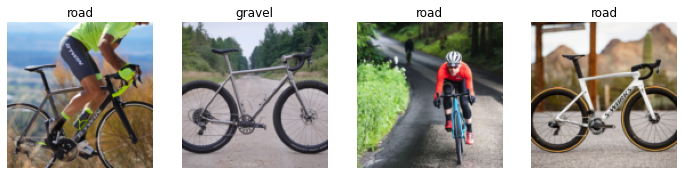

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

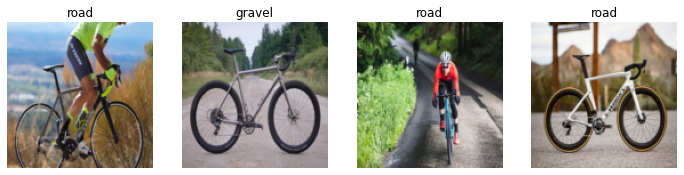

In [10]:
# squish to see the whole picture
bikes = bikes.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bikes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

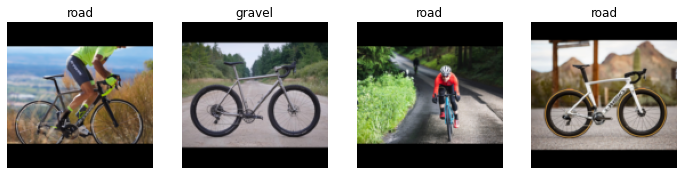

In [11]:
# padding
bikes = bikes.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bikes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

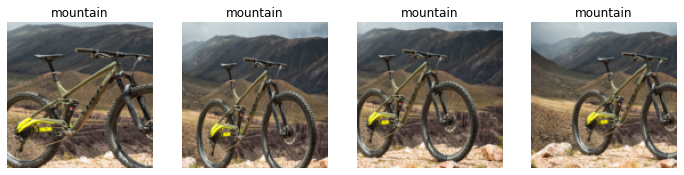

In [12]:
# radom risize prop
bikes = bikes.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bikes.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

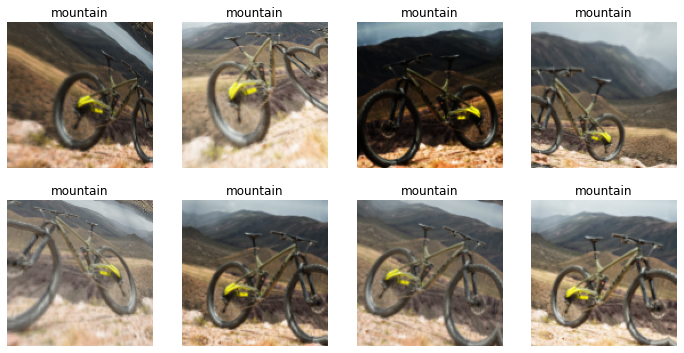

In [13]:
# data augmentation
bikes = bikes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bikes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training the model and using it to clean the data

In [14]:
bikes = bikes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bikes.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.051399,1.941847,0.685714,00:17


epoch,train_loss,valid_loss,error_rate,time
0,1.504805,1.415854,0.514286,00:17
1,1.460561,0.920126,0.342857,00:18
2,1.159832,0.593707,0.200000,00:17
3,0.990209,0.398627,0.228571,00:16
4,0.848568,0.296191,0.171429,00:16
5,0.715179,0.262233,0.171429,00:18
6,0.622111,0.220774,0.114286,00:17
7,0.549853,0.188874,0.114286,00:17
8,0.485466,0.164650,0.057143,00:17
9,0.440218,0.155356,0.057143,00:17


View confusion matrix

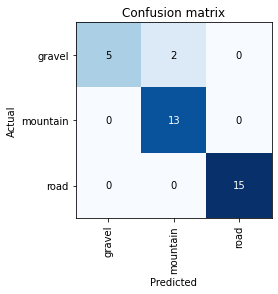

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

View highest errors

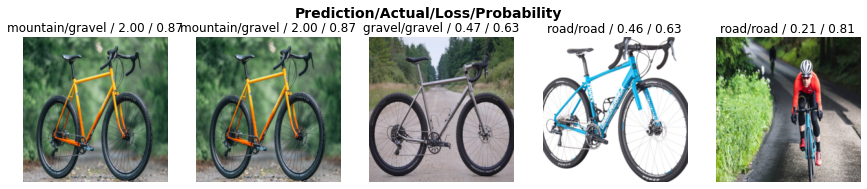

In [17]:
interp.plot_top_losses(5, nrows=1)

Change data based on errors

In [18]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [19]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Using the Model for Inference

In [20]:
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [21]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]